# plot FOV ovals on the ground

In [1]:
#  d duncan, 04/02/19
#  using Ellipse class of objects to map correct size and orientation of FOVs
#  on the ground from AMSR2 L1 data

from h5py import File

In [67]:
# read in L1R file and calculate spacecraft position in terms of geocentric lat/lon
afile = '/home/dudavid/src/1dvar/ocean_goes5_AMSR2/GW1AM2_201609211515_089A_L1SGRTBR_2220220.h5'
dorb = afile[-35:-20]
amf = File(afile)

altitude = 1e3* float(bytes.decode(amf.attrs['SatelliteAltitude'][0])[:-2]) # assumed constant for all scans
print(altitude,'m')
navd = amf['Navigation Data'][:] # first 3 are X,Y,Z in WGS84 positioning
print(navd.shape)
# azimuth angle of FOV, relative to N, [-180<az<180] (scaled in h5 file)
az   = amf['Earth Azimuth'][30:-30,:]*.01 

#zen  = amf['Earth Incidence'][:,30:-30]*.01 

# choose channels and convolution resolution (these are native except 89!)
tblist = ['Brightness Temperature (res06,6.9GHz,V)','Brightness Temperature (res06,6.9GHz,H)',\
          'Brightness Temperature (res06,7.3GHz,V)','Brightness Temperature (res06,7.3GHz,H)',\
          'Brightness Temperature (res10,10.7GHz,V)','Brightness Temperature (res10,10.7GHz,H)',\
          'Brightness Temperature (res23,18.7GHz,V)','Brightness Temperature (res23,18.7GHz,H)',\
          'Brightness Temperature (res23,23.8GHz,V)','Brightness Temperature (res23,23.8GHz,H)',\
          'Brightness Temperature (res36,36.5GHz,V)','Brightness Temperature (res36,36.5GHz,H)',\
          'Brightness Temperature (original,89GHz-A,V)','Brightness Temperature (original,89GHz-A,H)' ] 
nch = len(tblist)
ch_str = ['6V','6H','7V','7H','10V','10H','18V','18H','23V','23H','36V','36H','89V','89H']
npix = 243
nscans = np.shape(amf[tblist[0]][:])[0] 
print(nscans)
tbs = np.zeros([nscans,npix,nch])
for c,chstr in enumerate(tblist):
    if c<nch-2:  # last 2 in list have 486 pixels across
        tbs[:,:,c] = .01 * amf[chstr][:,:]  # tbs saved with factor 100
    else:
        tbs[:,:,c] = .01 * amf[chstr][:,::2]  # take every other original 89 to match low freqs

# NOTE: there are 30 'overlap' scans included on either end of JAXA files, so shrink array to match L1C:
nscans -= 30*2
tbs = tbs[30:-30, :, :] #.reshape(nscans*npix,nch)
print(shinfo(tbs),nscans)    

alo = amf['Longitude of Observation Point for 89A'][30:-30,::2] # every other one has a low-freq
ala = amf['Latitude of Observation Point for 89A'][30:-30,::2]  # obs point (half the sampling)

from astropy.coordinates import EarthLocation
# ploc = EarthLocation.from_geodetic(lo[sc,px],la[sc,px], altitude,ellipsoid='WGS84')\n",
# sloc = EarthLocation.from_geocentric(navd[sc,0],navd[sc,1],navd[sc,2], unit='m') # for SC lat/lon/etc.\n",
# SClat, SClon = sloc.lat.value, sloc.lon.value\n",
# sensor_losGeometricFromSensorPosToOtherPositions will draw the line between two distinct points \n",
#   such as SCposition and position on the ground
SClat, SClon = np.zeros([nscans]), np.zeros([nscans])  ## just get SClat/SClon once per scan
sloc = EarthLocation.from_geocentric(navd[30:-30,0],navd[30:-30,1],navd[30:-30,2], unit='m')
SClat[:], SClon[:] = sloc.lat.value, sloc.lon.value
#SClat[xpx,xsc], SClon[xpx,xsc] = sloc.lat.value, sloc.lon.value
print(info(ala[:,122]-SClat))
#print(ala[122,1000],SClat[1000])

699600.0 m
(2041, 6)
2041
['7.47E+1', '3.75E+2', '1.87E+2', '5.50E+1', (1981, 243, 14)] 1981
['-3.13E+0', '7.48E+0', '6.79E+0', '1.71E+0']


In [11]:
# pick a scan number, then select a range of pixels/scans around it in a square
scm = 1000 # scan midpoint of 2D scene


# Lats and lons
lat0     = 0  # center of grid in lat, lon
lon0     = 0
nlat, nlon = 10, 10    # number of lat and lon divisions
latwid, lonwid = 4, 4  # just asssume square for now
 
lat_grid = lat0 + np.linspace(-latwid,latwid,nlat) # [-3:0.25:3]
lon_grid = lon0 + np.linspace(-lonwid,lonwid,nlat) # [-3:0.25:3]
 
#nlat     = length(lat_grid)
#nlon     = length(lon_grid)
#xmlStore( fullfile(wfolder,'lat_grid.xml'), lat_grid, 'Vector' );
#xmlStore( fullfile(wfolder,'lon_grid.xml'), lon_grid, 'Vector' );

In [12]:
# Surface properties

s_names = ['Water skin temperature','Wind speed','Wind direction','Salinity']
s_data = np.zeros([len(s_names), lat_grid.size, lon_grid.size])

#surface_props_data     = zeros( length(surface_props_names), length(lat_grid), length(lon_grid) );

tmean                     = 296   # sst mean
wsp                       = 7.3   # 10m wind speed
s_data[0,:,:] = tmean
s_data[0,2,4] = tmean+3.5 # some preturbation
s_data[1,:,:] = wsp
s_data[1,5,1] = wsp-3.2 # some perturbation
s_data[2,:,:] = 90 # token wind direction value
s_data[3,:,:] = 0.034 # token salinity value


In [13]:
widths  = np.array([35., 35., 24., 14., 15.,  7., 3.]) # in km across
heights = np.array([62., 62., 42., 22., 26., 12., 5.]) #  per freq, 6/7/10/18/23/36/89

# convert (roughly!) to deg near equator... okay as first approximation for plotting:
widths *= 360.0/40075.
heights*= 360.0/40075. # deg/circumference

### if wanting to get more exact with widths/heights of FOVs, can back out lat/lon differences
###  for edge of FOVs using positions with this package:
#from astropy import coordinates
#from astropy.coordinates import EarthLocation
#ploc = EarthLocation.from_geodetic(arts_pos[0,0,1],arts_pos[0,0,0], 0.0,ellipsoid='WGS84')
#ploc.

(6804,)


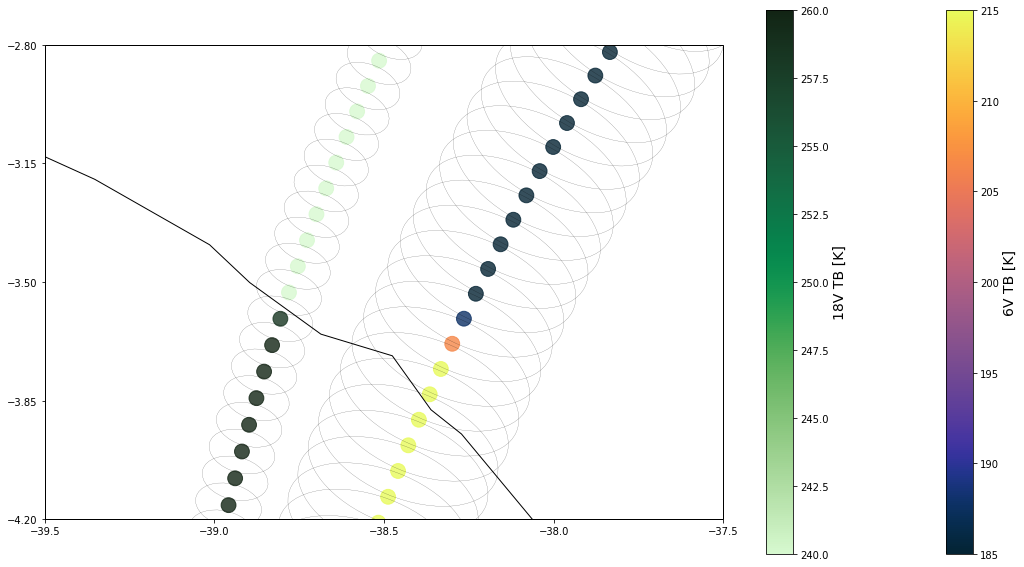

In [84]:
from matplotlib.patches import Ellipse
from cartopy import crs as ccrs
from cmocean import cm as cmo

sc = 1000
off = 10 # next scan

# provide x,y coords, width, height, angle of ellipse

ells = [Ellipse(xy=[alo[i,j],ala[i,j]], width=widths[int(k/2)], height=heights[int(k/2)], 
                angle=-az[i,j], linewidth=0.2, alpha=0.7, fill=False) 
        for i in np.arange(sc,sc+off+1,off) for j in range(npix) for k in range(nch)]
print(np.shape(ells))

#ax.fill(x, y, alpha=0.2, facecolor='yellow',
#        edgecolor='yellow', linewidth=1, zorder=1)
#ax.add_patch()

fig = plt.figure(figsize=[19,10])
projj = ccrs.PlateCarree()
ax = plt.subplot(111, projection=projj )

inn = 1.5 # additional deg or whatever on each side beyond lat/lon values
reg = [np.min(ala[sc,:])-inn,np.max(ala[sc,:])+inn+.8, 
       np.min(alo[sc,:])-inn,np.max(alo[sc,:])+inn]
reg=[-4.2,-2.8,-39.5,-37.5]  ## region is close to Fortaleza, Brazil
#ax.set_xlim(left=np.min(lon_grid)+inn,right=np.max(lon_grid)-inn)
#ax.set_ylim(bottom=np.min(lat_grid)+inn,top=np.max(lat_grid)-inn)
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])

nx,ny = 5,5
ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

othr=6
for e in ells[0::nch][0:npix]: #[-npix:-1]:  # 19V
    ax.add_artist(e)
for e in ells[othr::nch][npix:]: #[-npix:-1]:  # so just 6V right now, first scan
    ax.add_artist(e)

ann = 30
#vmin = np.min(tbs[sc:sc+off+1,:,0]) + ann
#vmax = np.max(tbs[sc:sc+off+1,:,0]) - ann
vmin0, vmax0= 200-15, 200+15
thenorm = plt.Normalize(vmin = vmin0, vmax = vmax0)
#vmin = np.min(tbs[sc:sc+off+1,:,othr]) + ann*2
#vmax = np.max(tbs[sc:sc+off+1,:,othr]) - ann*2
vmin1, vmax1 = 250-10, 250+10
thenorm1 = plt.Normalize(vmin = vmin1, vmax = vmax1)
ceem1, ceem = cmo.algae, cmo.thermal
#ax.pcolormesh(lon_grid, lat_grid, s_data[0,:,:], norm=thenorm1, 
#             transform=projj, cmap=cmo.algae)

#thenorm=plt.Normalize(vmin=vmin,vmax=vmax)
ax.scatter( alo[sc+off,:], ala[sc+off,:], s=220.0, c=tbs[sc+off,:,othr], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem1, norm=thenorm1);
ax.scatter( alo[sc,:], ala[sc,:],         s=220.0, c=tbs[sc,:,0], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
ax.coastlines(resolution='50m');

fs = 14
sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax)
cb.set_label(ch_str[0]+' TB [K]', fontsize=fs)

sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
sm1._A = []
cb1 = plt.colorbar(sm1,ax=ax)
cb1.set_label(ch_str[othr]+' TB [K]', fontsize=fs)

plt.savefig('sample_fovsz.png',bbox_inches='tight',dpi=400)
plt.show()


(150,)
(1981, 243)


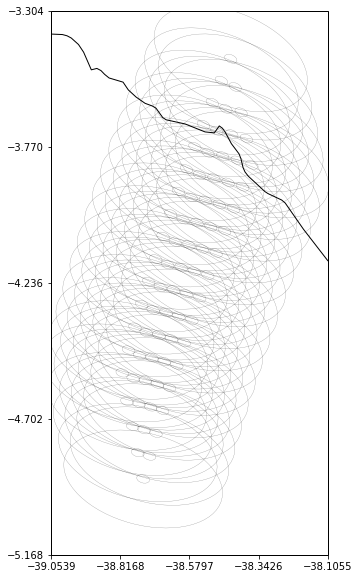

In [85]:

#sc = 1000
#off = 1 # next scan
pixr = np.arange(215,230)
scr  = np.arange(1000,1000+5)
chans = [0,12] # trying 6,89

# provide x,y coords, width, height, angle of ellipse

ells2 = [Ellipse(xy=[alo[i,j],ala[i,j]], width=widths[int(k/2)], height=heights[int(k/2)], 
                angle=-az[i,j], linewidth=0.25, alpha=0.5, fill=False) 
        for i in scr for j in pixr for k in chans]
print(np.shape(ells2))

fig = plt.figure(figsize=[19,10])
projj = ccrs.PlateCarree()
ax = plt.subplot(111, projection=projj )

inn = .26
print(np.shape(ala))
reg = [np.min(ala[scr[0]:scr[-1],pixr])-inn, np.max(ala[scr[0]:scr[-1],pixr])+inn, 
       np.min(alo[scr[0]:scr[-1],pixr])-inn, np.max(alo[scr[0]:scr[-1],pixr])+inn]
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])

nx,ny = 5,5
ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

for e in ells2[:]: # one of each freq
    ax.add_artist(e)

#vmin=np.min(tbs[:,:,0])-1
#vmax=np.max(tbs[:,:,0])+1
#thenorm=plt.Normalize(vmin=vmin,vmax=vmax)
#ax.scatter( alo[sc,:], ala[sc,:], s=60.0, c=tbs[sc,:,0], marker='o', \
#            transform=projj, alpha=0.8, cmap=cmo.thermal, norm=thenorm);
ax.coastlines(resolution='10m');
#sm = plt.cm.ScalarMappable(cmap=cmo.thermal, norm=thenorm)
#sm._A = []
#plt.colorbar(sm,ax=ax)

plt.savefig('ring_fovs.png',bbox_inches='tight',dpi=400)
plt.show()